## BDT - Testing 500

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import math

#### Load Samples

In [2]:
signal_all = pd.DataFrame()
signal_mass = [300, 420, 440, 460, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 2000] #All signals
for each in signal_mass:
    df_temp = pd.read_csv(str(each) + ".csv", index_col=0)
    df_temp.drop(columns=["nTags", "MCChannelNumber", "mVHres"], inplace=True)
    signal_all = pd.concat([df_temp, signal_all], ignore_index=True)
    
signal_500 = pd.read_csv('500.csv', index_col=0) #Want to test 500
signal_500.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)
    
background = pd.read_csv("background.csv", index_col=0)
background.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)

background = background[background["weight"]>0 ] #Only positive Bkg Weight

#### train_test_split on signals and bkg separately:

In [3]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2) 
train_signal, test_signal = train_test_split(signal_all, test_size=0.4, random_state=2)

#### Change the weights of training signal so the sum is the same as that of bkg:

In [4]:
train_signal_weight = train_signal["weight"] * np.sum(train_bkg["weight"])/np.sum(train_signal["weight"])

test_signal_weight = signal_500["weight"] * np.sum(test_bkg["weight"])/np.sum(signal_500["weight"])
    
test_bkg_weight = test_bkg["weight"].to_numpy()

train_bkg_weight = train_bkg["weight"].to_numpy()

#### Combine train_signal and train_bkg:

In [5]:
train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(signal_500) * [1] 

train_x = pd.concat([train_bkg, train_signal], ignore_index=True) 
test_x = pd.concat([test_bkg, signal_500], ignore_index=True) 

#### Assign the weights to a different variable and drop weights from train_x 

In [6]:
train_weight = train_x["weight"].to_numpy()
test_weight = test_x["weight"].to_numpy()

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

#### Fit with train_x:

In [7]:
BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", 
                                 n_estimators=50, learning_rate=1).fit(train_x,train_y,train_weight)

In [8]:
bkg_train = BDT_clf.decision_function(train_bkg.drop(columns=["weight"]))
signal_train = BDT_clf.decision_function(train_signal.drop(columns=["weight"]))
bkg_test = BDT_clf.decision_function(test_bkg.drop(columns=["weight"]))
signal_test = BDT_clf.decision_function(signal_500.drop(columns=["weight"]))

#### Plots and significance:

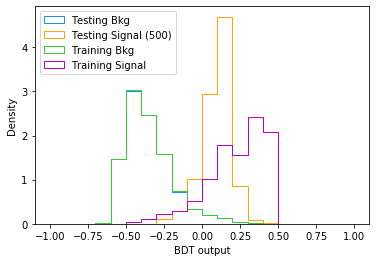

In [9]:
c_max = 1
c_min = -1

bins = np.linspace(-1,1,20)

plt.hist(bkg_test,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, weights = test_bkg_weight, 
         color ='dodgerblue', label="Testing Bkg")
plt.hist(signal_test,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, weights = test_signal_weight, 
             color ='orange', label="Testing Signal (500)")
plt.hist(bkg_train,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, weights = train_bkg_weight, 
             color ='limegreen', label="Training Bkg")
plt.hist(signal_train,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, weights = train_signal_weight,
             color ='m', label="Training Signal")
        
plt.xlabel('BDT output')
plt.ylabel('Density')
plt.legend(loc="upper left")

sighist, _ = np.histogram(signal_test, bins=bins, weights=test_signal_weight)
bkghist, _ = np.histogram(bkg_test, bins=bins, weights=test_bkg_weight)
sighist_train, _ = np.histogram(signal_train, bins=bins, weights=train_signal_weight)
bkghist_train, _ = np.histogram(bkg_train, bins=bins, weights=train_bkg_weight)

In [10]:
portion = 0.4
logsig = True
    
backgrounds_content = np.array(bkghist)/portion
signal_content = np.array(sighist)/portion
backgrounds_content_train = np.array(bkghist_train)/portion
signal_content_train = np.array(sighist_train)/portion
    
total = 0

for each_b, each_s in zip(backgrounds_content, signal_content):
    if each_b > 0 and each_s > 0:
        total += 2 * ((each_s + each_b) * math.log(1 + each_s/each_b) - each_s)
test_signif = "Testing significance is:",math.sqrt(total)

for each_b, each_s in zip(backgrounds_content_train, signal_content_train):
    if each_b > 0 and each_s > 0:
        total += 2 * ((each_s + each_b) * math.log(1 + each_s/each_b) - each_s)
train_signif = "Training significance is:", math.sqrt(total)   
    
print(test_signif)
print(train_signif)

('Testing significance is:', 339.01008602556567)
('Training significance is:', 599.6448168865909)


In [ ]:
#('Testing significance is:', 338.8680720578327)
#('Training significance is:', 599.5645405226064)